In [1]:
# Import previously pre-processed data
import pandas as pd 
df = pd.read_csv("neg_preprocessed_clean_y.csv")
df.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14075 entries, 0 to 14074
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   text              14075 non-null  object 
 1   rating            14075 non-null  float64
 2   resp_text         1510 non-null   object 
 3   response_timing   14075 non-null  int64  
 4   response_length   14075 non-null  float64
 5   general_personal  14075 non-null  int64  
 6   price_range       14075 non-null  int64  
dtypes: float64(2), int64(3), object(2)
memory usage: 769.9+ KB


In [1]:
import pandas as pd 

df = pd.read_csv("extra_preprocessed.csv")

In [4]:
# Show me the rows with nan in price_range
df[df['price_range'].isnull()]

# Drop rows with nan in price_range
df = df.dropna(subset=['price_range'])


In [6]:
df.to_csv("extra_preprocessed.csv", index=False)

(8445, 6) (2815, 6) (2815, 6)
(8445, 1004) (2815, 1004) (2815, 1004)
accuracy score: 0.5620 ,test F1 score: 0.5202


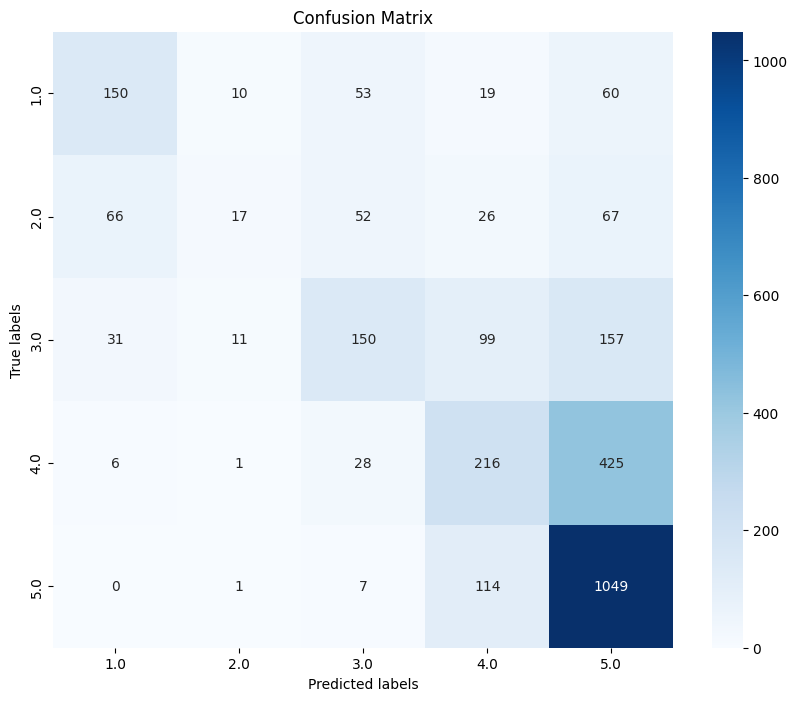

In [16]:
# Random Forest
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from nltk.corpus import stopwords
from scipy.sparse import hstack
from sklearn.metrics import accuracy_score
import numpy as np

# Turn resp_text into a string
df['resp_text'] = df['resp_text'].fillna('').astype(str)

# Create X (dropped rating) and y (rating)
X = df.drop(columns='rating')
y = df['rating']

# split the data 60/20/20

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, stratify=y_train, random_state=42)

print(X_train.shape, X_val.shape, X_test.shape)

# Create a CountVectorizer object
vectorizer = CountVectorizer(max_features=1000, stop_words=stopwords.words("english"))

# Concatenate 'text' and 'resp_text' columns into a single column
X_train_combined_text = X_train['text'] + ' ' + X_train['resp_text']
X_val_combined_text = X_val['text'] + ' ' + X_val['resp_text']
X_test_combined_text = X_test['text'] + ' ' + X_test['resp_text']


# Fit the vectorizer on the combined text data
vectorizer.fit(X_train_combined_text)

# Transform the combined text data for training, validation, and test sets
X_train_text = vectorizer.transform(X_train_combined_text)
X_val_text = vectorizer.transform(X_val_combined_text)
X_test_text = vectorizer.transform(X_test_combined_text)

# Transform numerical features into a sparse matrix
X_train_numeric = X_train.drop(columns=['text', 'resp_text']).values
X_val_numeric = X_val.drop(columns=['text', 'resp_text']).values
X_test_numeric = X_test.drop(columns=['text', 'resp_text']).values

# Concatenate text features with numerical features
X_train_combined = hstack([X_train_text, X_train_numeric])
X_val_combined = hstack([X_val_text, X_val_numeric])
X_test_combined = hstack([X_test_text, X_test_numeric])

# Now X_train_combined, X_val_combined, and X_test_combined contain both text and numerical features
print(X_train_combined.shape, X_val_combined.shape, X_test_combined.shape)

# Define the best parameters
best_params = {
    'oob_score': True,
    'n_estimators': 1000,
    'min_samples_leaf': 1,
    'max_samples': 0.5,
    'max_features': 'sqrt',
    'bootstrap': True
}

# Create a Random Forest classifier
rf = RandomForestClassifier(**best_params, random_state=42)

# Fit the model on the training data
rf.fit(X_train_combined, y_train)

# Predict the ratings on the validation data
y_val_pred = rf.predict(X_val_combined)

# Calculate the F1 score
f_val = f1_score(y_val, y_val_pred, average='weighted')

# Predict the ratings on the test data
y_test_pred = rf.predict(X_test_combined)

# Calculate the F1 score  v  
f_test = f1_score(y_test, y_test_pred, average='weighted')
acc_test = accuracy_score(y_test, y_test_pred)

# Print both scores
print(f'accuracy score: {acc_test:.4f} ,test F1 score: {f_test:.4f}')

# Create confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Create a confusion matrix
cm = confusion_matrix(y_test, y_test_pred)

# Show the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=rf.classes_, yticklabels=rf.classes_)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix_rf_simple.png' , dpi=300)


(8445, 2) (2815, 2) (2815, 2)
(8445, 1000) (2815, 1000) (2815, 1000)
accuracy score: 0.5517 ,test F1 score: 0.5190


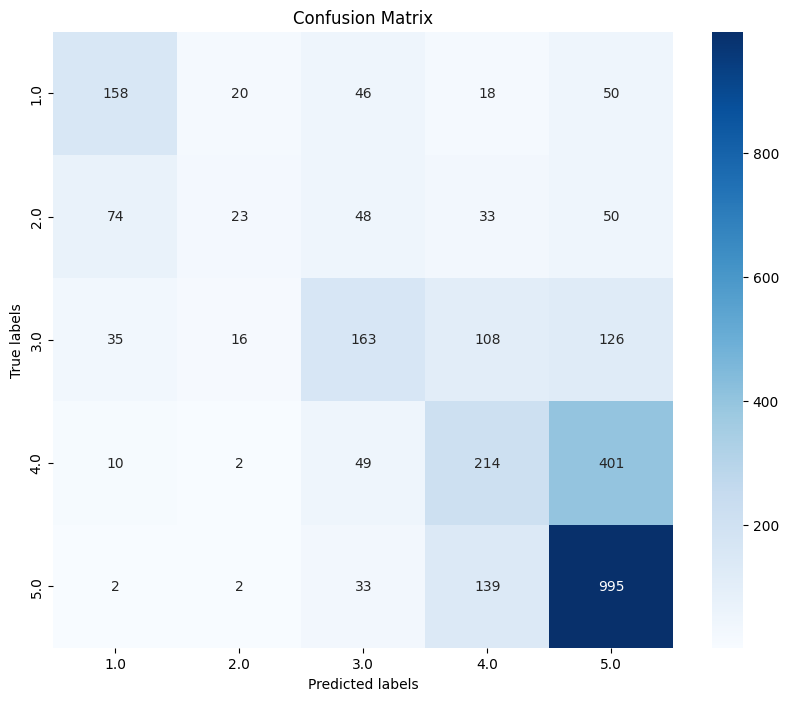

In [17]:
# Random Forest
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from nltk.corpus import stopwords
from scipy.sparse import hstack
from sklearn.metrics import accuracy_score
import numpy as np

# Turn resp_text into a string
df['resp_text'] = df['resp_text'].fillna('').astype(str)

# Create X (dropped rating) and y (rating)
X = df[['text', 'resp_text']]
y = df['rating']

# split the data 60/20/20

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, stratify=y_train, random_state=42)

print(X_train.shape, X_val.shape, X_test.shape)

# Create a CountVectorizer object
vectorizer = CountVectorizer(max_features=1000, stop_words=stopwords.words("english"))

# Concatenate 'text' and 'resp_text' columns into a single column
X_train_combined_text = X_train['text'] + ' ' + X_train['resp_text']
X_val_combined_text = X_val['text'] + ' ' + X_val['resp_text']
X_test_combined_text = X_test['text'] + ' ' + X_test['resp_text']


# Fit the vectorizer on the combined text data
vectorizer.fit(X_train_combined_text)

# Transform the combined text data for training, validation, and test sets
X_train_text = vectorizer.transform(X_train_combined_text)
X_val_text = vectorizer.transform(X_val_combined_text)
X_test_text = vectorizer.transform(X_test_combined_text)

# # Transform numerical features into a sparse matrix
# X_train_numeric = X_train.drop(columns=['text', 'resp_text']).values
# X_val_numeric = X_val.drop(columns=['text', 'resp_text']).values
# X_test_numeric = X_test.drop(columns=['text', 'resp_text']).values

# # Concatenate text features with numerical features
# X_train_combined = hstack([X_train_text, X_train_numeric])
# X_val_combined = hstack([X_val_text, X_val_numeric])
# X_test_combined = hstack([X_test_text, X_test_numeric])

# Now X_train_combined, X_val_combined, and X_test_combined contain both text and numerical features
print(X_train_text.shape, X_val_text.shape, X_test_text.shape)

# Create a Random Forest classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the model on the training data
rf.fit(X_train_text, y_train)

# Predict the ratings on the validation data
y_val_pred = rf.predict(X_val_text)

# Calculate the F1 score
f_val = f1_score(y_val, y_val_pred, average='weighted')

# Predict the ratings on the test data
y_test_pred = rf.predict(X_test_text)

# Calculate the F1 score  v  
f_test = f1_score(y_test, y_test_pred, average='weighted')
acc_test = accuracy_score(y_test, y_test_pred)

# Print both scores
print(f'accuracy score: {acc_test:.4f} ,test F1 score: {f_test:.4f}')

# Create confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Create a confusion matrix
cm = confusion_matrix(y_test, y_test_pred)

# Show the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=rf.classes_, yticklabels=rf.classes_)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix_rf_add.png' , dpi=300)


Fitting 5 folds for each of 100 candidates, totalling 500 fits


C:\Users\35989\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
355 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
45 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\35989\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\35989\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-pa

Best parameters: {'oob_score': True, 'n_estimators': 1000, 'min_samples_leaf': 1, 'max_samples': 0.5, 'max_features': 'sqrt', 'bootstrap': True}
validation F1 score: 0.5278 ,test F1 score: 0.5202


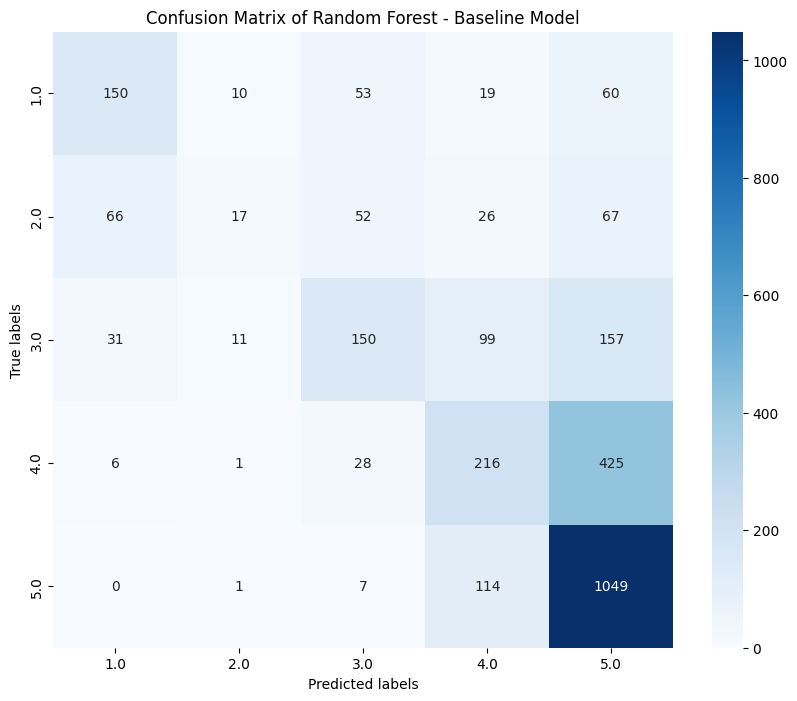

<Figure size 640x480 with 0 Axes>

In [15]:
# Using random search
# Initiate randomm search for the random forest 
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

# Define the hyperparameters
n_trees = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
replace = [True, False]
sample_fraction = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
mtry = ['sqrt', 'auto', 'p', 0.257]
respect_unordered_factors = [True, False]
min_node_size = [1, 5, 10, 15, 20]
# Create the random grid
random_grid = {
    'n_estimators': n_trees,
    'bootstrap': replace,
    'max_samples': sample_fraction,
    'max_features': mtry,
    'oob_score': respect_unordered_factors,
    'min_samples_leaf': min_node_size
}
# Create a RandomizedSearchCV object
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid,
                                n_iter = 100, cv = 5, verbose=2, random_state=42, n_jobs = -1)

# Fit the model on the training data
rf_random.fit(X_train_combined, y_train)

# Get the best parameters
best_params = rf_random.best_params_

# Train a new Random Forest model with the best parameters
best_rf_model = RandomForestClassifier(random_state=42, **best_params)
best_rf_model.fit(X_train_combined, y_train)

# Predict the ratings on the validation data
y_val_pred = best_rf_model.predict(X_val_combined)

# Calculate the F1 score
f_val = f1_score(y_val, y_val_pred, average='weighted')

# Predict the ratings on the test data
y_test_pred = best_rf_model.predict(X_test_combined)

# Calculate the F1 score  v  
f_test = f1_score(y_test, y_test_pred, average='weighted')

# Print both scores
print(f'Best parameters: {best_params}')
print(f'validation F1 score: {f_val:.4f} ,test F1 score: {f_test:.4f}')

# Get the confusion matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Get the confusion matrix
cm = confusion_matrix(y_test, y_test_pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=rf.classes_, yticklabels=rf.classes_)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix of Random Forest - Baseline Model')
plt.show()

# Save the plot with 300 dpi and as pdf
plt.savefig('confusion_matrix_baseline.pdf', dpi=300)


In [4]:
# Random Forest - graph
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from nltk.corpus import stopwords
from scipy.sparse import hstack

# define lists to collect scores
val_f1_scores, test_f1_scores, val_acc_scores, test_acc_scores = list(), list(), list(), list()

# Turn resp_text into a string
df['resp_text'] = df['resp_text'].fillna('').astype(str)

# Create X (dropped rating) and y (rating)
X = df.drop('rating', axis=1)

y = df['rating']

# Split the data into training/validation/testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, stratify=y_train, random_state=42)

# Create a CountVectorizer object
vectorizer = CountVectorizer(max_features=1000, stop_words=stopwords.words("english"))

# Concatenate 'text' and 'resp_text' columns into a single column
X_train_combined_text = X_train['text'] + ' ' + X_train['resp_text']
X_val_combined_text = X_val['text'] + ' ' + X_val['resp_text']
X_test_combined_text = X_test['text'] + ' ' + X_test['resp_text']

# Replace NaN values with empty strings in combined text data
X_train_combined_text.fillna('', inplace=True)
X_val_combined_text.fillna('', inplace=True)
X_test_combined_text.fillna('', inplace=True)

# Fit the vectorizer on the combined text data
vectorizer.fit(X_train_combined_text)

# Transform the combined text data for training, validation, and test sets
X_train_text = vectorizer.transform(X_train_combined_text)
X_val_text = vectorizer.transform(X_val_combined_text)
X_test_text = vectorizer.transform(X_test_combined_text)

# Transform numerical features into a sparse matrix
X_train_numeric = X_train.drop(columns=['text', 'resp_text']).values
X_val_numeric = X_val.drop(columns=['text', 'resp_text']).values
X_test_numeric = X_test.drop(columns=['text', 'resp_text']).values

# Concatenate text features with numerical features
X_train_combined = hstack([X_train_text, X_train_numeric])
X_val_combined = hstack([X_val_text, X_val_numeric])
X_test_combined = hstack([X_test_text, X_test_numeric])

# Now X_train_combined, X_val_combined, and X_test_combined contain both text and numerical features
print(X_train_combined.shape, X_val_combined.shape, X_test_combined.shape)

# define the tree depths to evaluate 
values = [i for i in range(65, 81)]

# evaluate a decision tree for each depth
for i in values:
 # configure the model
 model = RandomForestClassifier(n_estimators=100, max_depth=i, random_state=42)
 # fit model on the training dataset
 model.fit(X_train_combined, y_train)
 # evaluate on the train dataset
 y_val_pred = model.predict(X_val_combined)
 val_f1 = f1_score(y_val, y_val_pred, average='weighted')
 val_accuracy = accuracy_score(y_val, y_val_pred)
 val_f1_scores.append(val_f1)
 val_acc_scores.append(val_accuracy)
 # evaluate on the test dataset
 y_test_pred = model.predict(X_test_combined)
 test_f1 = f1_score(y_test, y_test_pred, average='weighted')
 test_accuracy = accuracy_score(y_test, y_test_pred)
 test_f1_scores.append(test_f1)
 test_acc_scores.append(test_accuracy)
 # summarize progress
 print('>%d, train f1: %.3f, test f1: %.3f, train acc: %.3f, test acc: %.3f' % (i,val_f1, test_f1, val_accuracy, test_accuracy))



(8445, 1004) (2815, 1004) (2815, 1004)
>65, train f1: 0.522, test f1: 0.516, train acc: 0.561, test acc: 0.557
>66, train f1: 0.521, test f1: 0.512, train acc: 0.560, test acc: 0.555
>67, train f1: 0.529, test f1: 0.508, train acc: 0.569, test acc: 0.551
>68, train f1: 0.528, test f1: 0.505, train acc: 0.568, test acc: 0.549
>69, train f1: 0.526, test f1: 0.511, train acc: 0.567, test acc: 0.550
>70, train f1: 0.524, test f1: 0.517, train acc: 0.565, test acc: 0.557
>71, train f1: 0.530, test f1: 0.515, train acc: 0.570, test acc: 0.556
>72, train f1: 0.528, test f1: 0.508, train acc: 0.568, test acc: 0.549
>73, train f1: 0.524, test f1: 0.517, train acc: 0.562, test acc: 0.557
>74, train f1: 0.534, test f1: 0.518, train acc: 0.571, test acc: 0.557
>75, train f1: 0.531, test f1: 0.514, train acc: 0.569, test acc: 0.554
>76, train f1: 0.533, test f1: 0.517, train acc: 0.571, test acc: 0.558
>77, train f1: 0.525, test f1: 0.511, train acc: 0.564, test acc: 0.552
>78, train f1: 0.530, tes

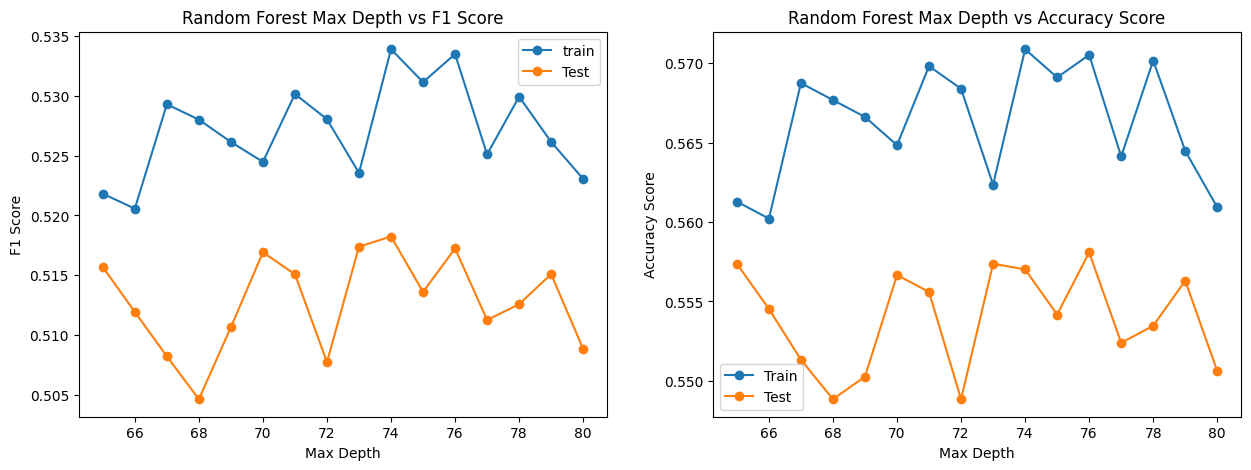

In [5]:
# Plot both on a subplot, one next to another 
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].plot(values, val_f1_scores, '-o', label='train')
axs[0].plot(values, test_f1_scores, '-o', label='Test')
axs[0].set_xlabel('Max Depth')
axs[0].set_ylabel('F1 Score')
axs[0].set_title('Random Forest Max Depth vs F1 Score')
axs[0].legend()

axs[1].plot(values, val_acc_scores, '-o', label='Train')
axs[1].plot(values, test_acc_scores, '-o', label='Test')
axs[1].set_xlabel('Max Depth')
axs[1].set_ylabel('Accuracy Score')
axs[1].set_title('Random Forest Max Depth vs Accuracy Score')
axs[1].legend()

plt.savefig('random_forest_max_depth.png')

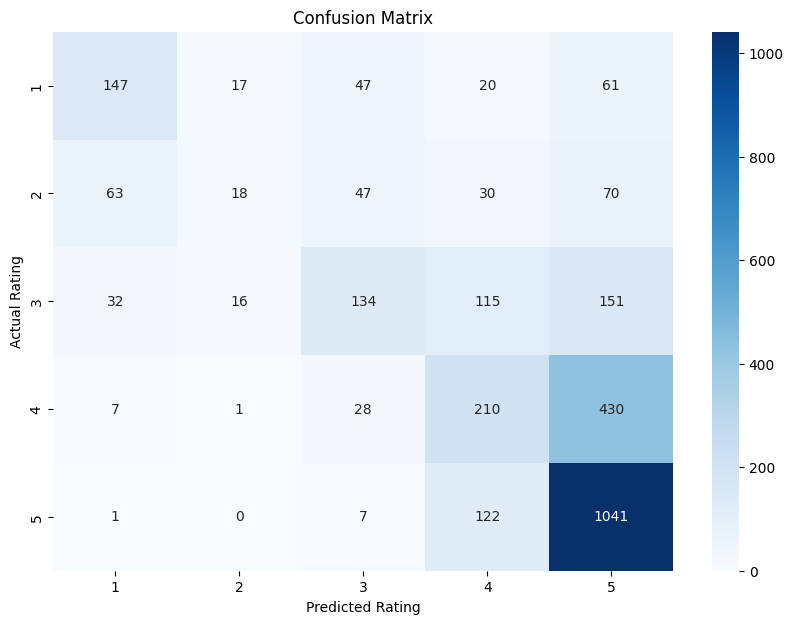

<Figure size 640x480 with 0 Axes>

In [6]:
# confusion matrix for the best model from the for loop
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Create a confusion matrix
cm = confusion_matrix(y_test, y_test_pred)

# Create a DataFrame from the confusion matrix
cm_df = pd.DataFrame(cm, index=['1', '2', '3', '4', '5'], columns=['1', '2', '3', '4', '5'])

# Create a heatmap from the confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='d')
plt.xlabel('Predicted Rating')
plt.ylabel('Actual Rating')
plt.title('Confusion Matrix')
plt.show()

plt.savefig('confusion_matrix.png')